In [115]:
import warnings

warnings.filterwarnings('ignore')

In [1]:
from google.colab import files
uploaded = files.upload()

Saving test.csv.zip to test.csv.zip
Saving train.csv.zip to train.csv.zip


In [2]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [3]:
import pandas as pd

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train = df_train.sample(frac=1, random_state = 33) #shuffle the data set

In [4]:
df_train=df_train.drop(columns = ['subject'], axis=1) #drop the data of the subject that was used to measure the data

In [47]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

#We use around 20% of the training data for validation
X_train = df_train.iloc[:6000,:-1]
y_train = df_train.iloc[:6000,-1]
X_val = df_train.iloc[6000:, :-1]
y_val = df_train.iloc[6000:,-1]
X_test = df_test.iloc[:,:-1].drop(columns = ['subject'])
y_test = df_test.iloc[:,-1]

#We one-hot encode the target label
encoder = OneHotEncoder(sparse_output = False)
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1))
y_val = encoder.transform(np.array(y_val).reshape(-1,1))
y_test = encoder.transform(np.array(y_test).reshape(-1,1))

In [19]:
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

On this first part, we perform a baseline computation and implement a simple model in order to compare with neural networks later

In [104]:
#Baseline computation: choosing randomly among labels
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, F1Score

y_random_pred = encoder.transform(np.array(df_test.iloc[:,-1].sample(frac =1)).reshape(-1,1)) #random prediction

def scores(y_t,y_p):

  cce = CategoricalCrossentropy()
  acc = Accuracy()
  f1_score = F1Score()

  print('Categorical crossentropy:', cce(y_t,y_p).numpy())
  print('Accuracy:', acc(np.argmax(y_t, axis=1), np.argmax(y_p,axis=1)).numpy())
  print('F1 score:', f1_score(y_t,y_p).numpy())

  # Reset the state of the metrics after each evaluation
  acc.reset_state()
  f1_score.reset_state()

print('Random choice scores for test set:')
scores(y_test,y_random_pred)

Random choice scores for test set:
Categorical crossentropy: 13.394368
Accuracy: 0.16898541
F1 score: [0.16014893 0.17922604 0.17857137 0.1693548  0.16428567 0.16135877]


In [42]:
#Baseline 2: Logistic regression

from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(solver = 'saga', multi_class='auto', max_iter=1000) # Added multi_class and increased max_iter for convergence

lg.fit(X_train, df_train.iloc[:6000,-1])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='auto', solver='saga')

In [97]:
# Get predictions from the logistic regression model on the validation set
y_test_pred_lr = lg.predict(X_test)

# One-hot encode the logistic regression predictions to match the format of y_val
# The encoder expects a 2D array, so reshape the predictions
y_test_pred_lr_encoded = encoder.transform(y_test_pred_lr.reshape(-1, 1))

# Evaluate the logistic regression model on the validation set using the scores function
print("Logistic Regression Scores on Test Set:")
scores(y_test, y_test_pred_lr_encoded)

Logistic Regression Scores on Test Set:
Categorical crossentropy: 0.6508495
F1 score: [1.         0.9220917  0.93574655 0.96477485 0.9807229  0.95464355]


We now try with neural network. One using the full set of features, and another using a dimensionally reduced set of features coming from an autoencoder

In [36]:
optimizer = RMSprop(learning_rate = 0.0001) #this seemed like a good learning rate after several tries

In [54]:
model = Sequential()
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(6, activation = 'softmax'))

model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics =['Accuracy'])

In [55]:
early_stopping = EarlyStopping(monitor = 'val_Accuracy', patience = 20, restore_best_weights =True )
model_check = ModelCheckpoint(filepath = 'bestmodel.model.keras', monitor = 'val_loss', save_best_only= True)

In [56]:
history = model.fit(X_train, y_train, epochs = 120, batch_size = 128, validation_data = (X_val,y_val),
                    callbacks = [early_stopping, model_check])

Epoch 1/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - Accuracy: 0.2521 - loss: 1.6734 - val_Accuracy: 0.6028 - val_loss: 1.2245
Epoch 2/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Accuracy: 0.4350 - loss: 1.2971 - val_Accuracy: 0.6679 - val_loss: 0.9958
Epoch 3/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Accuracy: 0.5498 - loss: 1.0911 - val_Accuracy: 0.7256 - val_loss: 0.8436
Epoch 4/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Accuracy: 0.6038 - loss: 0.9453 - val_Accuracy: 0.7737 - val_loss: 0.7092
Epoch 5/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Accuracy: 0.6715 - loss: 0.8189 - val_Accuracy: 0.7751 - val_loss: 0.6137
Epoch 6/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Accuracy: 0.7184 - loss: 0.7180 - val_Accuracy: 0.8254 - val_loss: 0.5148
Epoch 7/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Accuracy: 0.7533 - loss: 0.6296 - val_Accuracy: 0.8587 - val_loss: 0.4430
Epoch 8/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Accuracy: 0.7841 - loss: 0.5526 - val_Accuracy: 0.8683 - 

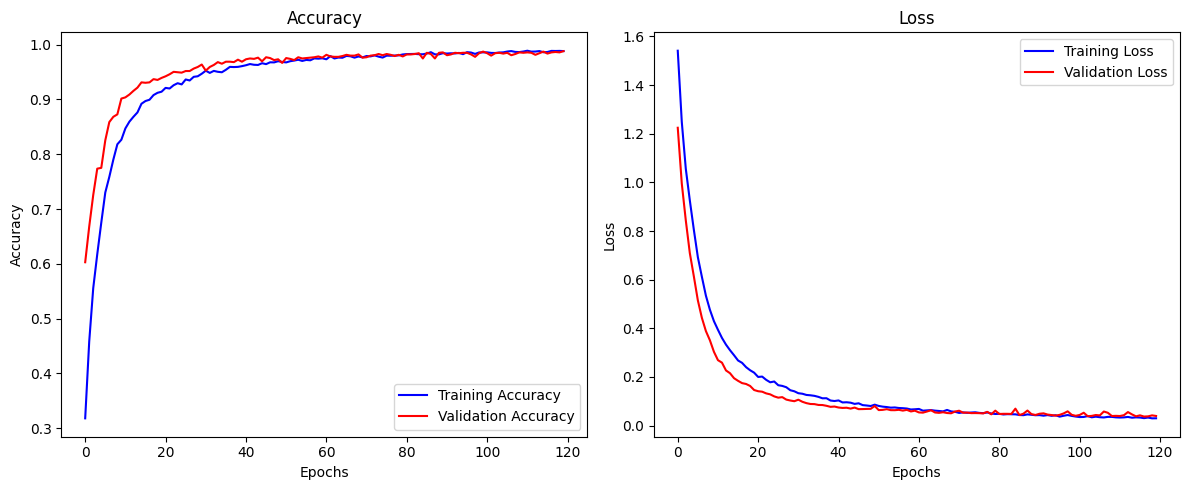

In [59]:
epochs = len(history.history['loss'])
import matplotlib.pyplot as plt
def plot_loss_acc(n_epochs, loss_history,val_loss_history, acc, val_acc):
  # Create a figure and a set of subplots (1 row, 2 columns)
  fig, ax = plt.subplots(1, 2, figsize=(12, 5))

  # Plot Accuracy on the first subplot
  ax[0].plot(range(n_epochs), acc,'b', label='Training Accuracy')
  ax[0].plot(range(n_epochs), val_acc,'r', label='Validation Accuracy')
  ax[0].set_title('Accuracy') # Set title on the axis
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()


  # Plot Loss on the second subplot
  ax[1].plot(range(n_epochs), loss_history,'b', label='Training Loss')
  ax[1].plot(range(n_epochs), val_loss_history,'r', label='Validation Loss')
  ax[1].set_title('Loss') # Set title on the axis
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend()

  plt.tight_layout()


# Call the plotting function
plot_loss_acc(epochs, history.history['loss'], history.history['val_loss'],
              history.history['Accuracy'], history.history['val_Accuracy'])

plt.show()

In [61]:
best_model = keras.models.load_model('bestmodel.model.keras')

In [62]:
best_model.evaluate(X_val,y_val)[0]

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Accuracy: 0.9887 - loss: 0.0320


0.037063971161842346

In [105]:
y_pred = best_model.predict(X_test)
print("NN scores on Test set")
scores(y_test,y_pred)
print("Logistic Regression Scores on Test Set:")
scores(y_test, y_test_pred_lr_encoded)

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
NN scores on Test set
Categorical crossentropy: 0.17026217
Accuracy: 0.9524941
F1 score: [0.9962616  0.92226887 0.9305301  0.96640307 0.9535452  0.9430379 ]
Logistic Regression Scores on Test Set:
Categorical crossentropy: 0.6508495
Accuracy: 0.95961994
F1 score: [1.         0.9220917  0.93574655 0.96477485 0.9807229  0.95464355]


In [106]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


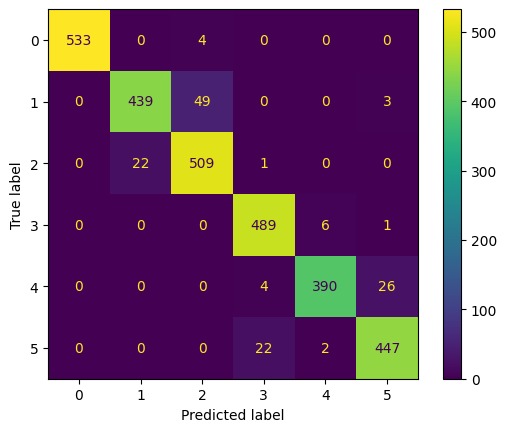

In [111]:
def conf_matrix(y_t,y_p):
  disp=ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_t,axis=1),np.argmax(y_p,axis=1)))
  #disp.plot(xticks_rotation=90)
  disp.plot()

conf_matrix(y_test,y_pred)

In [112]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
X_train_pca = pca.fit_transform(X_train)

In [113]:
X_train_pca.shape #67 components are kept if we want to explain 95% of the variance

(6000, 67)

In [116]:
def mse_reconstruction(true, reconstructed):
    return (np.sum(np.power(true - reconstructed, 2) / true.shape[1])).sum()

print(mse_reconstruction(X_train, pca.inverse_transform(X_train_pca)))

29.39104022735699


In [117]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [118]:
#Encoder part of the Auto-Encoder
input = Input(shape = (561,))
x= Dense(512, activation = 'tanh')(input) #We use tanh since the features are already normalized to be between -1 and 1
x= Dense(256, activation = 'tanh')(x)
x= Dense(128, activation = 'tanh')(x)
enc_output= Dense(64, activation = 'tanh')(x)
encoder = Model(inputs= input, outputs = enc_output)

In [120]:
#Decoder part of the Auto-Encoder
dec_input = Input(shape = (64,))
x= Dense(128, activation = 'tanh')(dec_input)
x= Dense(256, activation = 'tanh')(x)
x= Dense(512, activation = 'tanh')(x)
dec_output = Dense(561, activation = 'tanh')(x)
decoder = Model(inputs = dec_input, outputs = dec_output)

#Auto-Encoder
ae = Model(inputs = input, outputs = decoder(encoder(input)))
ae.compile(optimizer = 'rmsprop', loss ='mse')

model_check_ae = ModelCheckpoint(filepath = 'best_ae.model.keras', monitor = 'val_loss', save_best_only= True)

In [166]:
ae.fit(X_train,X_train, epochs= 50, batch_size = 32, callbacks =[model_check_ae], validation_data= (X_val,X_val))

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0044 - val_loss: 0.0052
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 

In [167]:
best_ae = keras.models.load_model('best_ae.model.keras')

In [168]:
best_ae.evaluate(X_val,X_val)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043


0.004369473084807396

In [169]:
X_train_rec = best_ae.predict(X_train)
X_val_rec = best_ae.predict(X_val)
X_test_rec = best_ae.predict(X_test)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)
print('MSE of val and test reconstruction using PCA:', mse_reconstruction (X_val,pca.inverse_transform(X_val_pca)), mse_reconstruction(X_test,pca.inverse_transform(X_test_pca)))
print('MSE of val and test reconstruction using AE:', mse_reconstruction (X_val,X_val_rec), mse_reconstruction(X_test,X_test_rec))

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
MSE of val and test reconstruction using PCA: 6.878892545466746 16.124858266866788
MSE of val and testreconstruction using AE: 5.907526957053843 15.148920296913852


In [170]:
X_train_enc = encoder.predict(X_train)
X_val_enc = encoder.predict(X_val)
X_test_enc = encoder.predict(X_test)


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [171]:
model_small = Sequential()
model_small.add(Dense(64, activation = 'relu'))
model_small.add(Dropout(0.3))
model_small.add(Dense(64, activation = 'relu'))
model_small.add(Dropout(0.3))
model_small.add(Dense(32, activation = 'relu'))
model_small.add(Dense(6, activation = 'softmax'))

model_small.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics =['Accuracy'])

In [172]:
early_stopping_small = EarlyStopping(monitor = 'val_Accuracy', patience = 20, restore_best_weights =True )
model_small_check = ModelCheckpoint(filepath = 'bestmodel_small.model.keras', monitor = 'val_loss', save_best_only= True)

In [173]:
history_small = model_small.fit(X_train_enc, y_train, epochs = 120, batch_size = 128, validation_data = (X_val_enc,y_val),
                    callbacks =  [model_small_check])

Epoch 1/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - Accuracy: 0.3687 - loss: 1.6193 - val_Accuracy: 0.8284 - val_loss: 0.8568
Epoch 2/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.7390 - loss: 0.7828 - val_Accuracy: 0.8979 - val_loss: 0.3524
Epoch 3/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.8261 - loss: 0.4444 - val_Accuracy: 0.9216 - val_loss: 0.2218
Epoch 4/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.8849 - loss: 0.2981 - val_Accuracy: 0.9357 - val_loss: 0.1670
Epoch 5/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.8977 - loss: 0.2475 - val_Accuracy: 0.9467 - val_loss: 0.1401
Epoch 6/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.9254 - loss: 0.1988 - val_Accuracy: 0.9564 - val_loss: 0.1251
Epoch 7/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.9297 - loss: 0.1767 - val_Accuracy: 0.9593 - val_loss: 0.1093
Epoch 8/120
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Accuracy: 0.9434 - loss: 0.1575 - val_Accuracy: 0.9645 - 

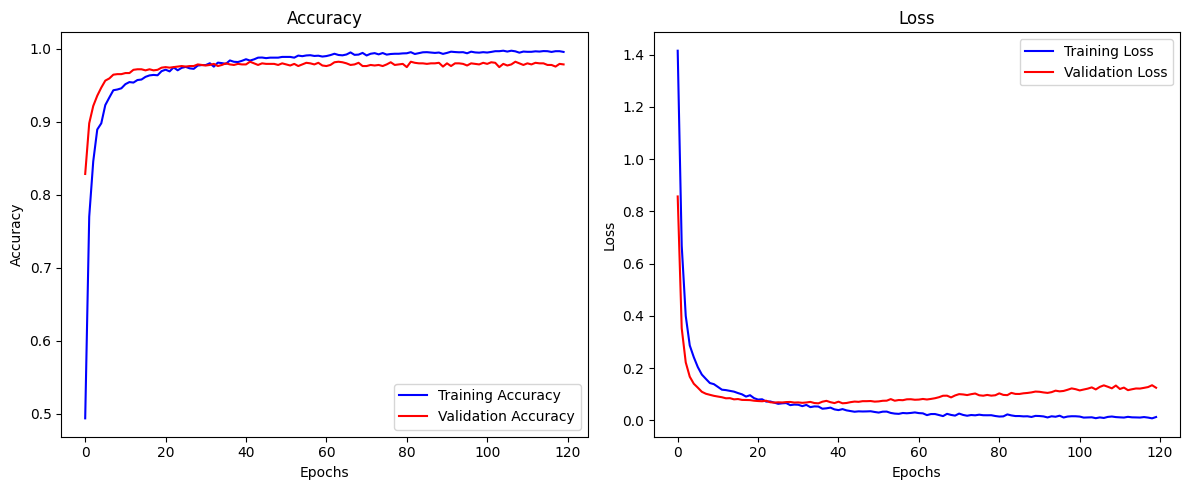

In [174]:
epochs = len(history_small.history['loss'])
plot_loss_acc(epochs, history_small.history['loss'],history_small.history['val_loss'],
              history_small.history['Accuracy'], history_small.history['val_Accuracy'])
plt.show()

In [175]:
best_small_model = keras.models.load_model('bestmodel_small.model.keras')

In [178]:
print("NN_small scores on Test set")
scores(y_test, best_small_model.predict(X_test_enc))
print("NN scores on Test set")
scores(y_test,y_pred)
print("Logistic Regression Scores on Test Set:")
scores(y_test, y_test_pred_lr_encoded)

NN_small scores on Test set
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Categorical crossentropy: 0.22775403
Accuracy: 0.9331524
F1 score: [0.9953227  0.90274835 0.91847813 0.929332   0.9363744  0.910891  ]
NN scores on Test set
Categorical crossentropy: 0.17026217
Accuracy: 0.9524941
F1 score: [0.9962616  0.92226887 0.9305301  0.96640307 0.9535452  0.9430379 ]
Logistic Regression Scores on Test Set:
Categorical crossentropy: 0.6508495
Accuracy: 0.95961994
F1 score: [1.         0.9220917  0.93574655 0.96477485 0.9807229  0.95464355]


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


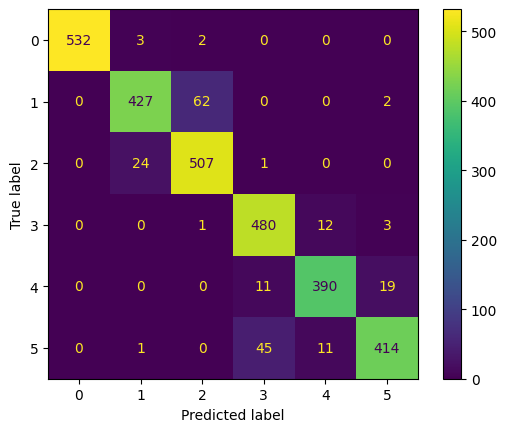

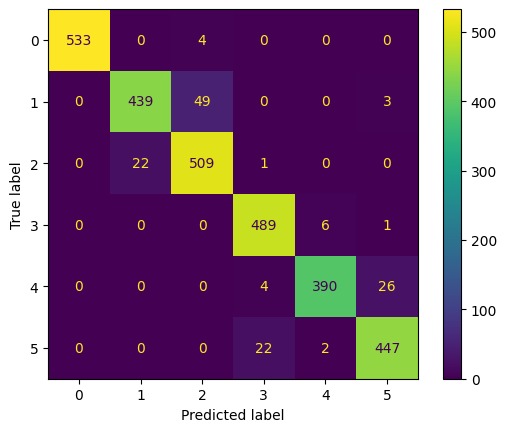

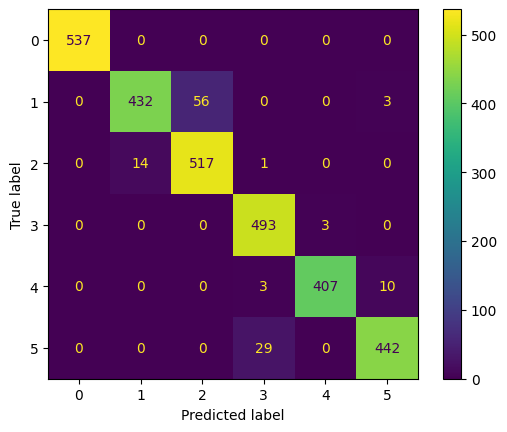

In [182]:

conf_matrix(y_test, best_small_model.predict(X_test_enc))
conf_matrix(y_test, y_pred)
conf_matrix(y_test, y_test_pred_lr_encoded)
